<a href="https://colab.research.google.com/github/mpalvarezc/DataMeasurements/blob/main/ProyectoFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Segmentación de Imágenes y Modelo de Regresión para la Estimación Automática de Medidas Corporales a partir de Máscaras de Imágenes**

##**1. Dataset**

Este conjunto de datos incluye 8978 siluetas frontales y laterales de 2505 sujetos reales, junto con su altura, peso y 14 medidas corporales. Los siguientes artefactos están disponibles para cada sujeto.

- Altura del sujeto
- Peso del sujeto
- Sexo del sujeto

Dos imágenes de siluetas en blanco y negro del sujeto de pie en pose frontal y lateral respectivamente con el cuerpo completo a la vista.

14 medidas corporales en cm: {circunferencia del tobillo, longitud del brazo, circunferencia del bíceps, circunferencia de la pantorrilla, circunferencia del pecho, circunferencia del antebrazo, altura, circunferencia de la cadera, longitud de la pierna, ancho de los hombros, longitud de los hombros a la entrepierna, circunferencia del muslo, circunferencia de la cintura, circunferencia de la muñeca}

Los datos se dividen en 3 conjuntos: entrenamiento, conjunto de prueba A, conjunto de prueba B. Para los conjuntos de entrenamiento y prueba A, los sujetos son fotografiados y escaneados en 3D en un laboratorio por técnicos. En el caso del conjunto de prueba B, los sujetos se escanean en el laboratorio, pero se fotografían en un entorno menos controlado con distintas orientaciones de la cámara y condiciones de iluminación, para simular la captura de imágenes en la naturaleza. Algunos sujetos fueron fotografiados más de una vez con diferentes prendas de vestir para comprobar la solidez del conjunto de datos.

[Link del dataset](https://registry.opendata.aws/bodym/)

##**1.1 Datos de entrenamiento y testing**

In [ ]:
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from tensorflow.keras.models import load_model
from tensorflow.keras import Input, Model
from tensorflow.keras import layers

In [ ]:
# Obtener las rutas de las imágenes de la persona correspondiente
def get_image_paths(subject_id, photo_map):
    """
    Obtiene las rutas de las imágenes (frontal y de perfil) para un sujeto dado.

    :param subject_id: ID del sujeto.
    :param photo_map: DataFrame que mapea los sujetos a las fotos.
    :return: Rutas de las imágenes frontal y de perfil.
    """
    subject_row = photo_map[photo_map['subject_id'] == subject_id]
    front_img_name = subject_row['photo_id'].values[0] + '.png'
    side_img_name = subject_row['photo_id'].values[0] + '.png'

    front_img_path = os.path.join(mask_folder, front_img_name)
    side_img_path = os.path.join(mask_left_folder, side_img_name)

    return front_img_path, side_img_path

Preprocesamiento de imágenes



In [ ]:
def keep_largest_white_area(image_path):
    """Keeps only the largest white area in a binary image.

    Args:
        image_path: Path to the input image.

    Returns:
        A NumPy array representing the processed image.
    """
    # Load the image in grayscale (binary)
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Threshold the image to make sure it's binary
    _, thresh = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

    # Find contours in the binary image
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Check if any contours were found
    if contours:
        # Find the contour with the largest area
        largest_contour = max(contours, key=cv2.contourArea)

        # Create a mask with only the largest contour filled
        mask = np.zeros_like(thresh)
        cv2.drawContours(mask, [largest_contour], -1, 255, cv2.FILLED)

        # Apply the mask to the original image
        result = cv2.bitwise_and(thresh, thresh, mask=mask)
    else:
        # Handle the case where no contours are found (e.g., return the original image)
        result = thresh
        print("Warning: No contours found in the image.")

    return result

In [ ]:
def preprocess_images(front_img_path, side_img_path, img_size=(128, 128)):
    """
    Preprocesses two images (front and side views) and combines them into a single 2-channel image.

    :param front_img_path: Path to the front view image.
    :param side_img_path: Path to the side view image.
    :param img_size: Final size of the images (width, height).
    :return: Numpy array of the combined image (2 channels).
    """
    # Keep only the largest white areas for both front and side images
    front_img_processed = keep_largest_white_area(front_img_path)
    side_img_processed = keep_largest_white_area(side_img_path)

    # Resize the processed images to the desired size
    front_img = Image.fromarray(front_img_processed).resize(img_size)
    side_img = Image.fromarray(side_img_processed).resize(img_size)

    # Convert images to numpy arrays
    front_img_array = np.array(front_img)
    side_img_array = np.array(side_img)

    # Combine the front and side images into a single array with two channels
    combined_img = np.stack([front_img_array, side_img_array], axis=-1)

    return combined_img

**Ejemplo de preprocesamiento**

- Redimensionamiento de la imagen a 128 x 128
- Combinación de imágenes a dos canales

In [ ]:
#Ruta de las carpetás de imágenes
mask_folder = "/content/drive/MyDrive/BodyM-Dataset/train/mask"
mask_left_folder = "/content/drive/MyDrive/BodyM-Dataset/train/mask_left"

#Cargar CSV de medidas y metadatos
hwg_metadata = pd.read_csv("/content/drive/MyDrive/BodyM-Dataset/train/hwg_metadata.csv")
measurements = pd.read_csv("/content/drive/MyDrive/BodyM-Dataset/train/measurements.csv")
photo_map = pd.read_csv("/content/drive/MyDrive/BodyM-Dataset/train/subject_to_photo_map.csv")

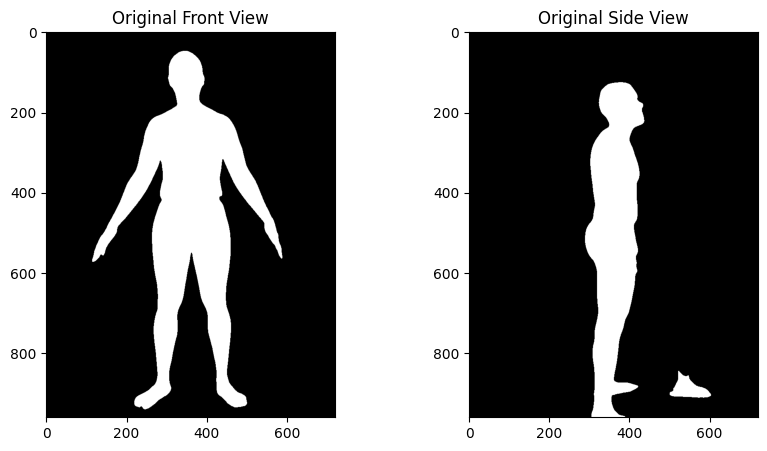

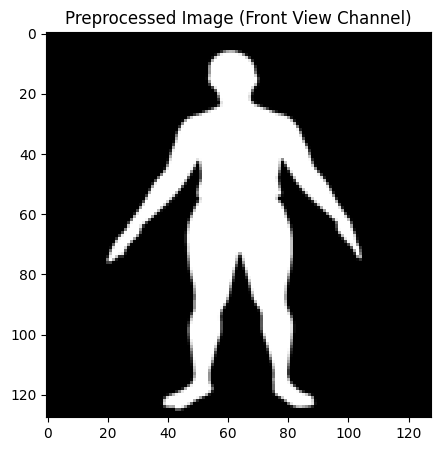

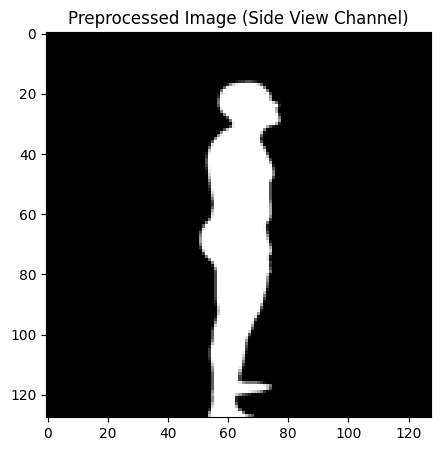

In [ ]:
subject_id = 1  # Replace with a valid subject ID from your data
front_img_path, side_img_path = get_image_paths("-494U-YoXOD8e8gkCuyaRLn4MLo5P8Dm2B1s59WBGdg", photo_map)

# Load and preprocess the images
original_front_img = cv2.imread(front_img_path, cv2.IMREAD_GRAYSCALE)
original_side_img = cv2.imread(side_img_path, cv2.IMREAD_GRAYSCALE)
preprocessed_img = preprocess_images(front_img_path, side_img_path)

# Display the original images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_front_img, cmap='gray')
plt.title('Original Front View')

plt.subplot(1, 2, 2)
plt.imshow(original_side_img, cmap='gray')
plt.title('Original Side View')
plt.show()

# Display the preprocessed image (combined with two channels)
plt.figure(figsize=(5, 5))
plt.imshow(preprocessed_img[..., 0], cmap='gray')  # Display the front view channel
plt.title('Preprocessed Image (Front View Channel)')
plt.show()

plt.figure(figsize=(5, 5))
plt.imshow(preprocessed_img[..., 1], cmap='gray')  # Display the side view channel
plt.title('Preprocessed Image (Side View Channel)')
plt.show()


In [ ]:
original_front_img.shape

(960, 720)

Datos de entrenamiento

In [ ]:
#Ruta de las carpetás de imágenes
mask_folder = "/content/drive/MyDrive/BodyM-Dataset/train/mask"
mask_left_folder = "/content/drive/MyDrive/BodyM-Dataset/train/mask_left"

#Cargar CSV de medidas y metadatos
hwg_metadata = pd.read_csv("/content/drive/MyDrive/BodyM-Dataset/train/hwg_metadata.csv")
measurements = pd.read_csv("/content/drive/MyDrive/BodyM-Dataset/train/measurements.csv")
photo_map = pd.read_csv("/content/drive/MyDrive/BodyM-Dataset/train/subject_to_photo_map.csv")

In [ ]:
# Preprocesar todas las imágenes y almacenarlas en un array
X = []
y = []


unique_photo_map = photo_map.drop_duplicates(subset=['subject_id'])
photo_map = unique_photo_map.sort_values('subject_id').reset_index(drop=True)

for index, row in photo_map.iterrows():
    subject_id = row['subject_id']

    # Obtener las rutas de las imágenes
    front_img_path, side_img_path = get_image_paths(subject_id, photo_map)

    # Preprocesar las imágenes
    processed_image = preprocess_images(front_img_path, side_img_path)
    X.append(processed_image)

    # Obtener las etiquetas (medidas corporales)
    subject_measures = measurements[measurements['subject_id'] == subject_id].iloc[0, 1:].values
    y.append(subject_measures)

# Convertir las listas en arrays de numpy
X = np.array(X)
y = np.array(y)

print(f"Shape de X: {X.shape}")  # (num_samples, 128, 128, 2)
print(f"Shape de y: {y.shape}")  # (num_samples, num_measures)

Shape de X: (2018, 128, 128, 2)
Shape de y: (2018, 14)


In [ ]:
# Ordenar por 'subject_id'
hwg_metadata_sorted = hwg_metadata.sort_values('subject_id')

# Eliminar la columna 'subject_id'
X_additional_features = hwg_metadata_sorted.drop('subject_id', axis=1)

# Reemplazar los valores NaN en la columna 'gender' con 'Unknown'
X_additional_features['gender'] = X_additional_features['gender'].fillna('Unknown')

# Mapear los valores de género a numéricos usando un diccionario
gender_mapping = {'male': 0, 'female': 1, 'Unknown': 2}
X_additional_features['gender'] = X_additional_features['gender'].map(gender_mapping).fillna(2)

# Convertir a numpy array
X_additional_features = X_additional_features.values


In [ ]:
print(f"Shape de X (imágenes): {X.shape}")
print(f"Shape de X (imágenes): {y.shape}")
print(f"Shape de X_additional_features (altura y peso): {X_additional_features.shape}")

Shape de X (imágenes): (2018, 128, 128, 2)
Shape de X (imágenes): (2018, 14)
Shape de X_additional_features (altura y peso): (2018, 3)


In [ ]:
from google.colab import drive
import os

In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Change the current working directory
os.chdir('/content/drive/MyDrive/BodyM-Dataset/train')

# Save the data
np.savez('data_train.npz', X=X, y=y, X_additional_features=X_additional_features)

# Verify the save location
print(os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/BodyM-Dataset/train


Datos de testing

In [ ]:
# Ruta de las carpetás de imágenes de validación
mask_folder = "/content/drive/MyDrive/BodyM-Dataset/testA/mask"
mask_left_folder = "/content/drive/MyDrive/BodyM-Dataset/testA/mask_left"

# Cargar CSV de medidas y metadatos de validación
hwg_metadata_test = pd.read_csv("/content/drive/MyDrive/BodyM-Dataset/testA/hwg_metadata.csv")
measurements_test = pd.read_csv("/content/drive/MyDrive/BodyM-Dataset/testA/measurements.csv")
photo_map_test = pd.read_csv("/content/drive/MyDrive/BodyM-Dataset/testA/subject_to_photo_map.csv")


In [ ]:

# Preprocesar todas las imágenes y almacenarlas en un array para validación
X_test = []
y_test = []

unique_photo_map_test = photo_map_test.drop_duplicates(subset=['subject_id'])
photo_map_test = unique_photo_map_test.sort_values('subject_id').reset_index(drop=True)

hwg_metadata_test_sorted = hwg_metadata_test.sort_values('subject_id')

for index, row in photo_map_test.iterrows():
    subject_id = row['subject_id']

    # Obtener las rutas de las imágenes
    front_img_path, side_img_path = get_image_paths(subject_id, photo_map_test)

    # Preprocesar las imágenes
    processed_image = preprocess_images(front_img_path, side_img_path)
    X_test.append(processed_image)

    # Obtener las etiquetas (medidas corporales)
    subject_measures = measurements_test[measurements_test['subject_id'] == subject_id].iloc[0, 1:].values
    y_test.append(subject_measures)

# Convertir las listas en arrays de numpy para validación
X_test = np.array(X_test)
y_test = np.array(y_test)

print(f"Shape de X_test: {X_test.shape}")  # (num_samples, 128, 128, 2)
print(f"Shape de y_test: {y_test.shape}")  # (num_samples, num_measures)



Shape de X_test: (87, 128, 128, 2)
Shape de y_test: (87, 14)


In [ ]:
hwg_metadata_sorted_test = hwg_metadata_test.sort_values('subject_id')

# Eliminar la columna 'subject_id'
X_additional_features_test = hwg_metadata_sorted_test.drop('subject_id', axis=1)

# Reemplazar los valores NaN en la columna 'gender' con 'Unknown'
X_additional_features_test['gender'] = X_additional_features_test['gender'].fillna('Unknown')

# Mapear los valores de género a numéricos usando un diccionario
gender_mapping = {'male': 0, 'female': 1, 'unknown': 2}
X_additional_features_test['gender'] = X_additional_features_test['gender'].map(gender_mapping).fillna(2)

# Convertir a numpy array
X_additional_features_test = X_additional_features_test.values


print(f"Shape de X_test (imágenes): {X_test.shape}")
print(f"Shape de y_test (imágenes): {y_test.shape}")
print(f"Shape de X_additional_features_test (altura y peso): {X_additional_features_test.shape}")

Shape de X_test (imágenes): (87, 128, 128, 2)
Shape de y_test (imágenes): (87, 14)
Shape de X_additional_features_test (altura y peso): (87, 3)


In [ ]:
# Change the current working directory to testA
os.chdir('/content/drive/MyDrive/BodyM-Dataset/testA')

# Save the data
np.savez('data_test.npz', X=X_test, y=y_test, X_additional_features=X_additional_features_test)

# Verify the save location
print(os.getcwd())

/content/drive/MyDrive/BodyM-Dataset/testA


**Cargue de los datos**

In [ ]:
# Load the data from the .npz file
data = np.load('/content/drive/MyDrive/BodyM-Dataset/train/data_train.npz', allow_pickle=True) # Added allow_pickle=True
X = data['X']
y = data['y']
X_additional_features = data['X_additional_features']

# Load the test data from the .npz file
data_test = np.load('/content/drive/MyDrive/BodyM-Dataset/testA/data_test.npz', allow_pickle=True) # Added allow_pickle=True
X_test = data_test['X']
y_test = data_test['y']
X_additional_features_test = data_test['X_additional_features']

##**1.2 EDA de datos de entrenamiento**

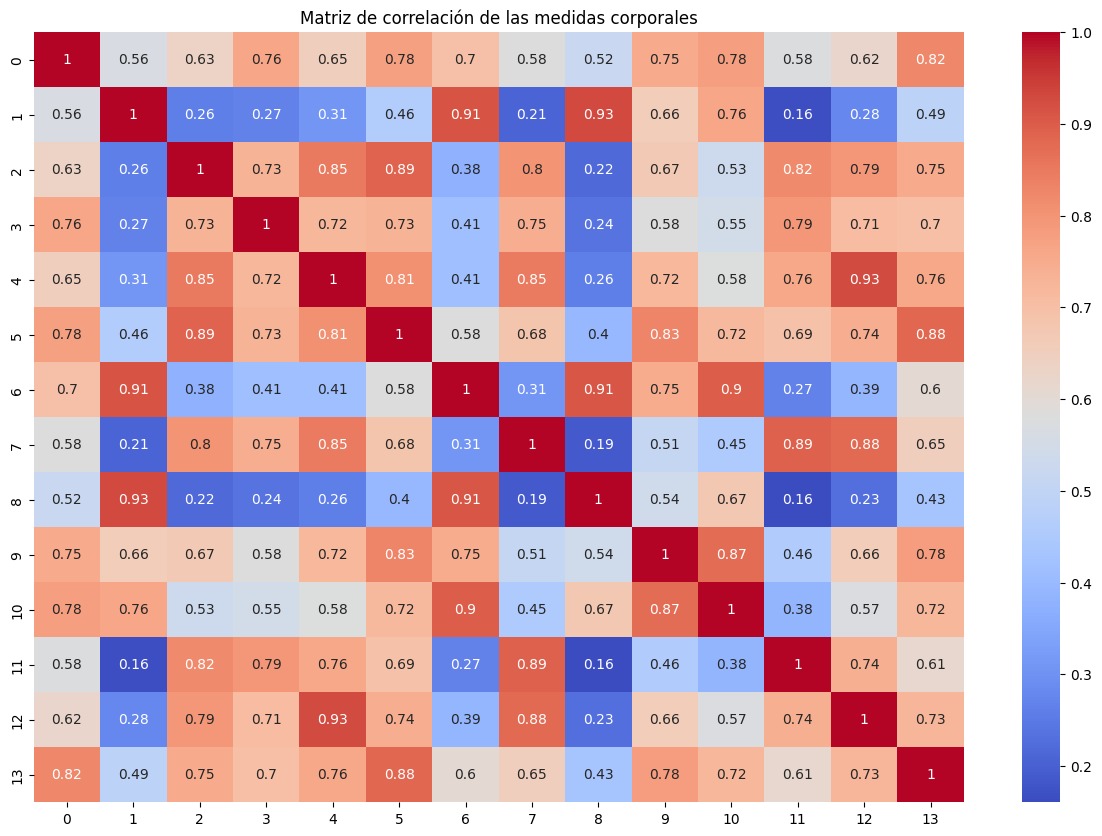

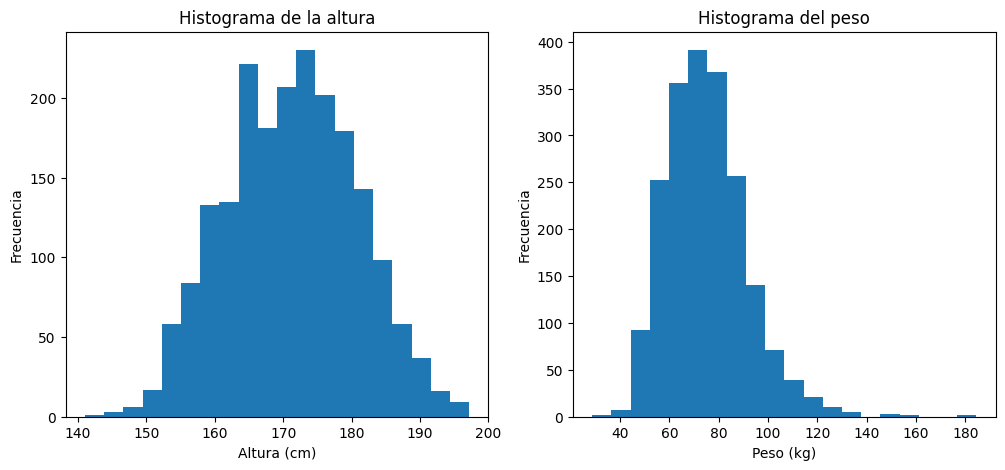

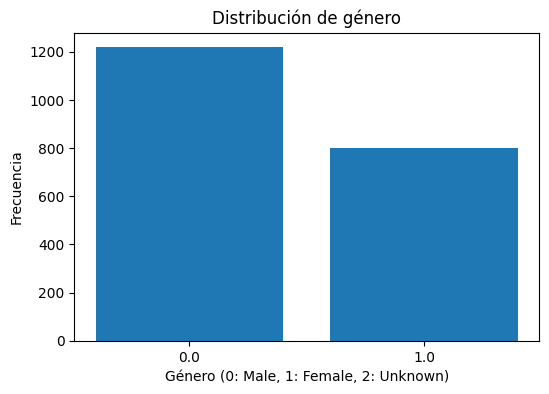

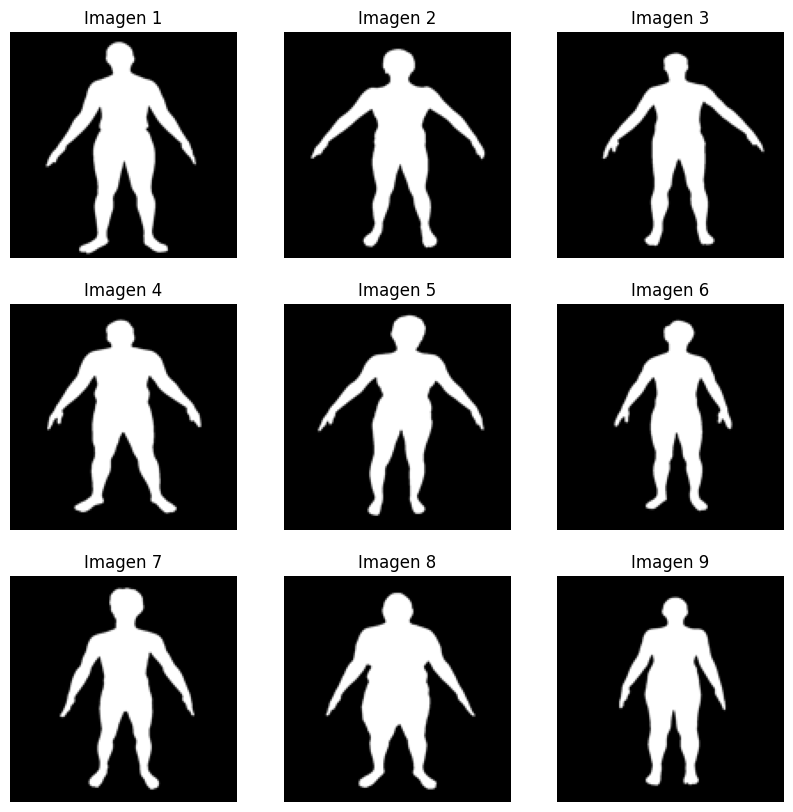

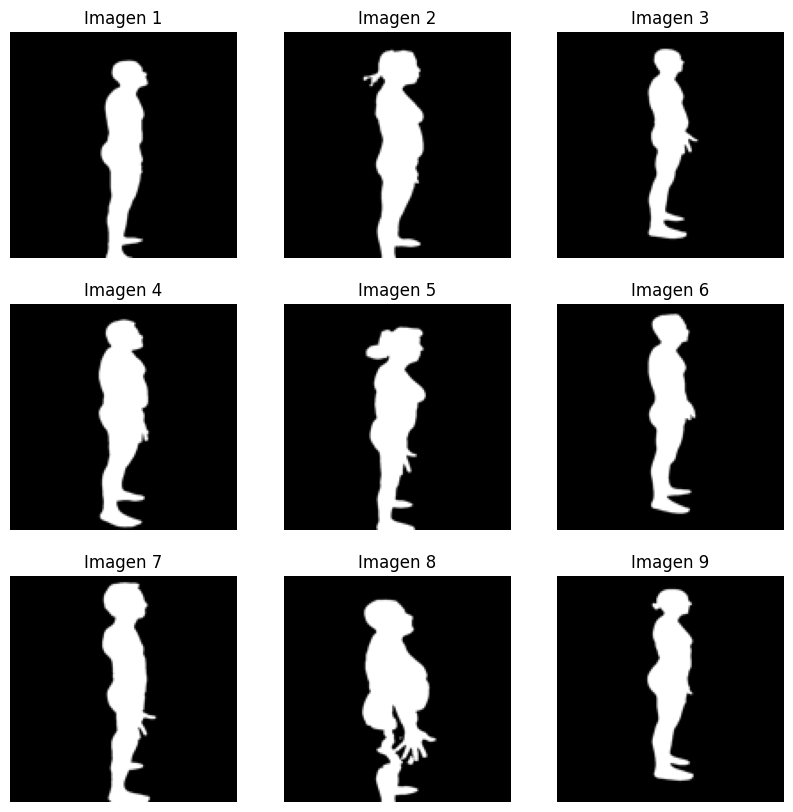

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Análisis de las variables de salida (medidas corporales)
plt.figure(figsize=(15, 10))
sns.heatmap(pd.DataFrame(y).corr(), annot=True, cmap='coolwarm')
plt.title('Matriz de correlación de las medidas corporales')
plt.show()

# Histograma de la altura y el peso
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(X_additional_features[:, 1], bins=20)
plt.title('Histograma de la altura')
plt.xlabel('Altura (cm)')
plt.ylabel('Frecuencia')

plt.subplot(1, 2, 2)
plt.hist(X_additional_features[:, 2], bins=20)
plt.title('Histograma del peso')
plt.xlabel('Peso (kg)')
plt.ylabel('Frecuencia')
plt.show()

# Distribución de género
gender_counts = pd.Series(X_additional_features[:, 0]).value_counts()
plt.figure(figsize=(6, 4))
gender_counts.index = gender_counts.index.astype(str)
plt.bar(gender_counts.index, gender_counts.values)
plt.title('Distribución de género')
plt.xlabel('Género (0: Male, 1: Female, 2: Unknown)')
plt.ylabel('Frecuencia')
plt.show()

# Visualización de algunas imágenes de ejemplo
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X[i, :, :, 0], cmap='gray')  # Mostrar la imagen frontal
    plt.title(f'Imagen {i+1}')
    plt.axis('off')
plt.show()

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X[i, :, :, 1], cmap='gray')  # Mostrar la imagen lateral
    plt.title(f'Imagen {i+1}')
    plt.axis('off')
plt.show()

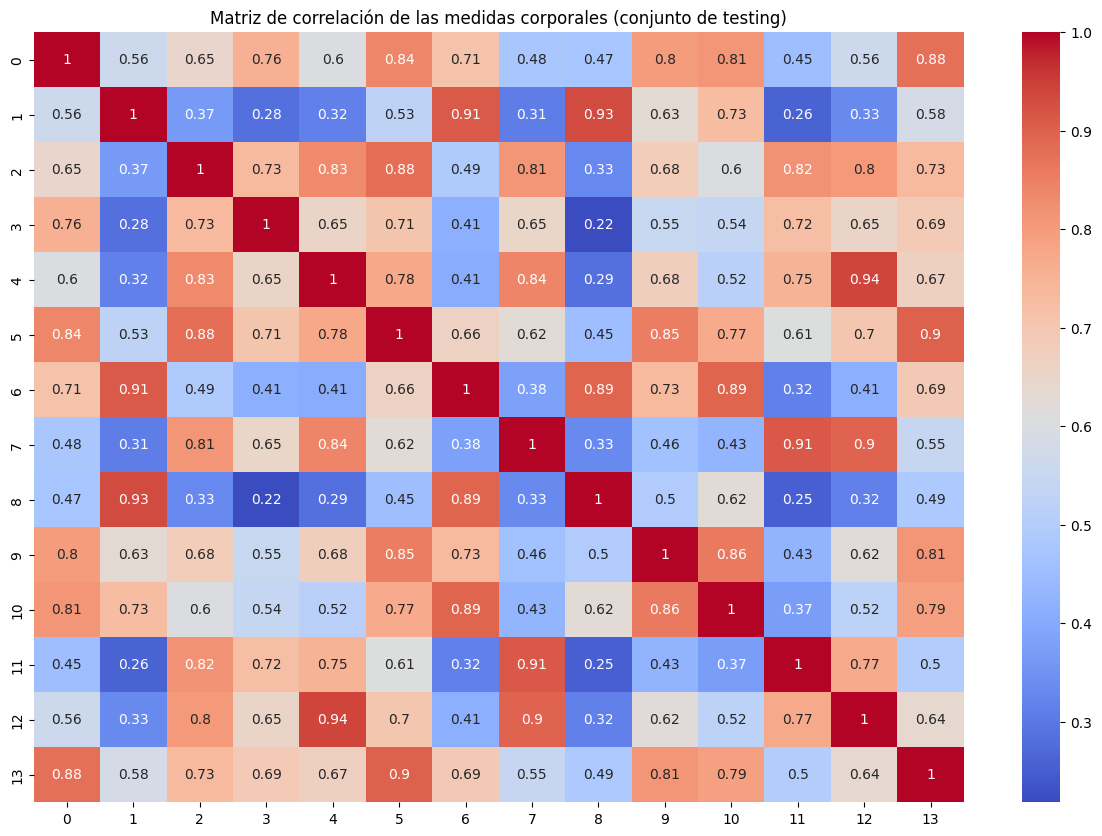

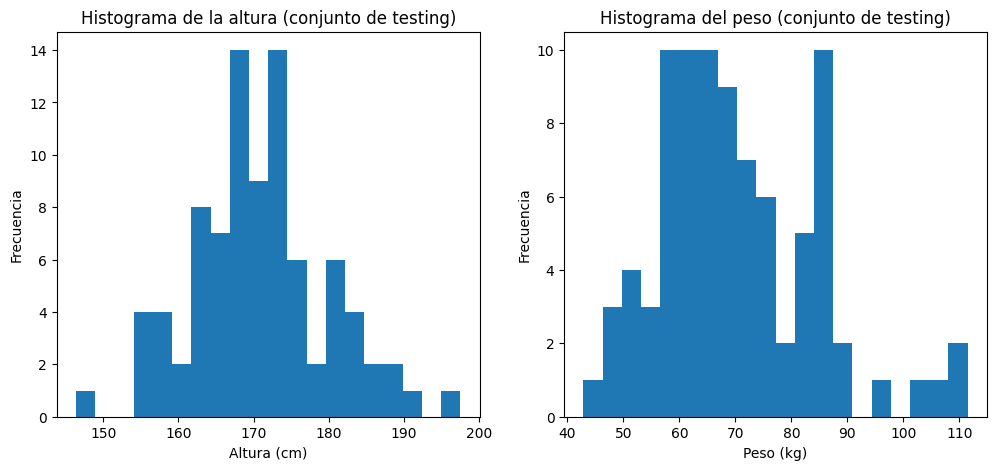

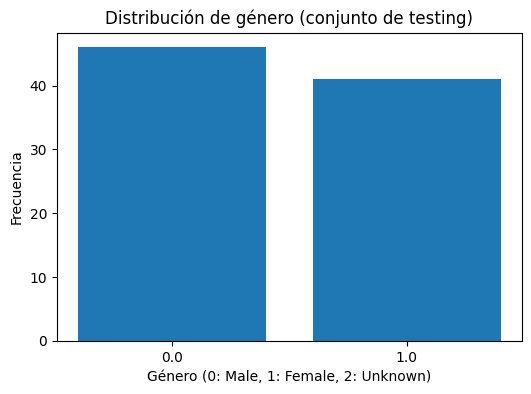

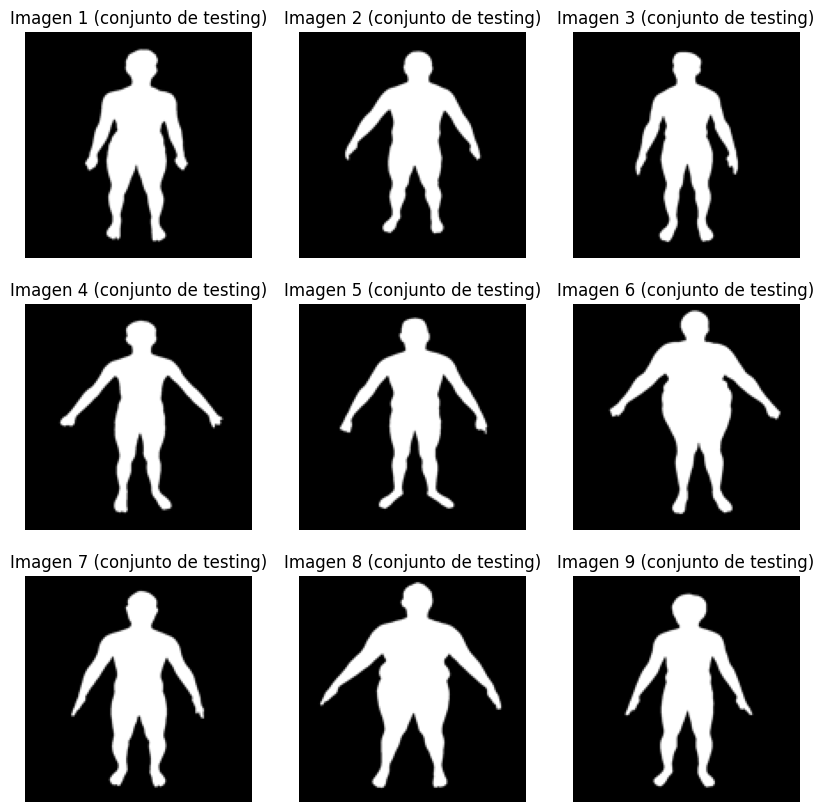

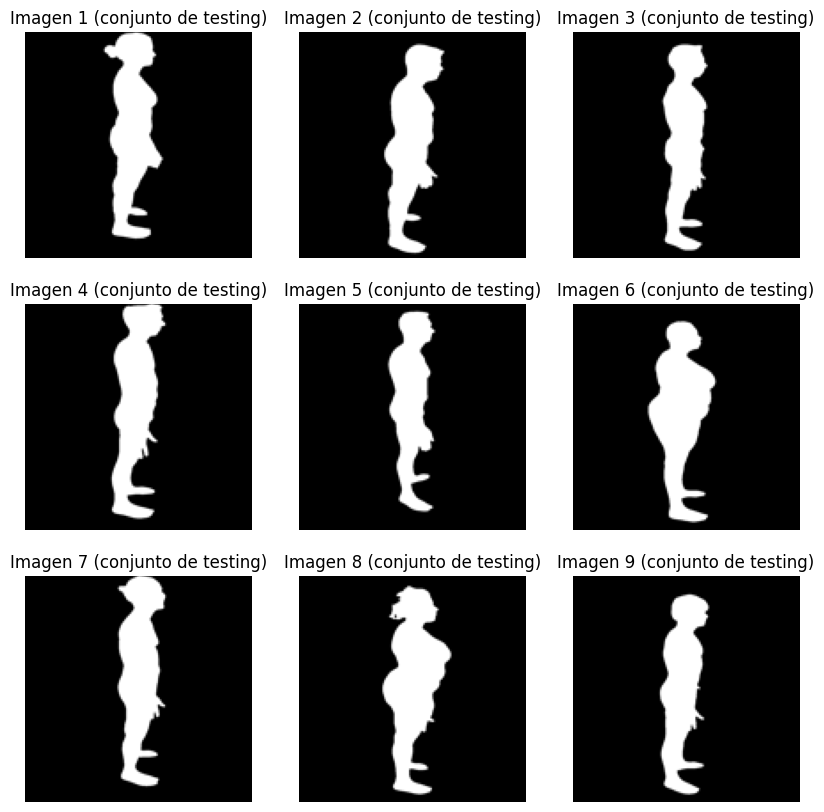

In [ ]:

# Análisis de las variables de salida (medidas corporales) para el conjunto de testing
plt.figure(figsize=(15, 10))
sns.heatmap(pd.DataFrame(y_test).corr(), annot=True, cmap='coolwarm')
plt.title('Matriz de correlación de las medidas corporales (conjunto de testing)')
plt.show()

# Histograma de la altura y el peso para el conjunto de testing
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(X_additional_features_test[:, 1], bins=20)
plt.title('Histograma de la altura (conjunto de testing)')
plt.xlabel('Altura (cm)')
plt.ylabel('Frecuencia')

plt.subplot(1, 2, 2)
plt.hist(X_additional_features_test[:, 2], bins=20)
plt.title('Histograma del peso (conjunto de testing)')
plt.xlabel('Peso (kg)')
plt.ylabel('Frecuencia')
plt.show()

# Distribución de género para el conjunto de prueba
gender_counts_test = pd.Series(X_additional_features_test[:, 0]).value_counts()
plt.figure(figsize=(6, 4))
gender_counts_test.index = gender_counts_test.index.astype(str)
plt.bar(gender_counts_test.index, gender_counts_test.values)
plt.title('Distribución de género (conjunto de testing)')
plt.xlabel('Género (0: Male, 1: Female, 2: Unknown)')
plt.ylabel('Frecuencia')
plt.show()

# Visualización de algunas imágenes de ejemplo del conjunto de testing
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_test[i, :, :, 0], cmap='gray')  # Mostrar la imagen frontal
    plt.title(f'Imagen {i+1} (conjunto de testing)')
    plt.axis('off')
plt.show()

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_test[i, :, :, 1], cmap='gray')  # Mostrar la imagen lateral
    plt.title(f'Imagen {i+1} (conjunto de testing)')
    plt.axis('off')
plt.show()

### **Front Images**


Train

In [ ]:
#Ruta de las carpetás de imágenes
mask_folder = "/content/drive/MyDrive/BodyM-Dataset/train/mask"
mask_left_folder = "/content/drive/MyDrive/BodyM-Dataset/train/mask_left"

#Cargar CSV de medidas y metadatos
hwg_metadata = pd.read_csv("/content/drive/MyDrive/BodyM-Dataset/train/hwg_metadata.csv")
measurements = pd.read_csv("/content/drive/MyDrive/BodyM-Dataset/train/measurements.csv")
photo_map = pd.read_csv("/content/drive/MyDrive/BodyM-Dataset/train/subject_to_photo_map.csv")

In [ ]:
def preprocess_front_images(front_img_path):
    """
    Preprocesses the front image.

    Args:
        front_img_path: Path to the front image.

    Returns:
        A NumPy array of shape (128, 128) containing the preprocessed image.
    """
    # Load image using OpenCV
    front_img = cv2.imread(front_img_path, cv2.IMREAD_GRAYSCALE)

    # Resize image to 128x128
    front_img = cv2.resize(front_img, (128, 128))

    return front_img  # return only the front image

In [ ]:
# Ejemplo de cómo obtener las rutas de las imágenes de la persona correspondiente
def get_image_paths_front(subject_id, photo_map):
    """
    Obtiene las rutas de las imágenes (frontal y de perfil) para un sujeto dado.

    :param subject_id: ID del sujeto.
    :param photo_map: DataFrame que mapea los sujetos a las fotos.
    :return: Rutas de las imágenes frontal y de perfil.
    """
    subject_row = photo_map[photo_map['subject_id'] == subject_id]
    front_img_name = subject_row['photo_id'].values[0] + '.png'

    front_img_path = os.path.join(mask_folder, front_img_name)

    return front_img_path

In [ ]:
# Preprocesar todas las imágenes y almacenarlas en un array
X_front = []  # List to store only frontal images
y = []

unique_photo_map = photo_map.drop_duplicates(subset=['subject_id'])
photo_map = unique_photo_map.sort_values('subject_id').reset_index(drop=True)

for index, row in photo_map.iterrows():
    subject_id = row['subject_id']

    # Obtener las rutas de las imágenes
    front_img_path = get_image_paths_front(subject_id, photo_map)  # Get only the front image path
    # Removed the _ as we are expecting only one return value

    # Preprocesar la imagen frontal
    processed_front_image = preprocess_front_images(front_img_path)
    X_front.append(processed_front_image)

    # Obtener las etiquetas (medidas corporales)
    subject_measures = measurements[measurements['subject_id'] == subject_id].iloc[0, 1:].values
    y.append(subject_measures)

# Convertir las listas en arrays de numpy
X_front = np.array(X_front)
y = np.array(y)

print(f"Shape de X_front: {X_front.shape}")  # (num_samples, 128, 128)
print(f"Shape de y: {y.shape}")  # (num_samples, num_measures)

Shape de X_front: (2018, 128, 128)
Shape de y: (2018, 14)


Test

In [ ]:
# Ruta de las carpetás de imágenes de validación
mask_folder = "/content/drive/MyDrive/BodyM-Dataset/testA/mask"
mask_left_folder = "/content/drive/MyDrive/BodyM-Dataset/testA/mask_left"

# Cargar CSV de medidas y metadatos de validación
hwg_metadata_test = pd.read_csv("/content/drive/MyDrive/BodyM-Dataset/testA/hwg_metadata.csv")
measurements_test = pd.read_csv("/content/drive/MyDrive/BodyM-Dataset/testA/measurements.csv")
photo_map_test = pd.read_csv("/content/drive/MyDrive/BodyM-Dataset/testA/subject_to_photo_map.csv")

# Preprocesar todas las imágenes y almacenarlas en un array para validación
X_front_test = []
y_test = []

unique_photo_map_test = photo_map_test.drop_duplicates(subset=['subject_id'])
photo_map_test = unique_photo_map_test.sort_values('subject_id').reset_index(drop=True)

hwg_metadata_test_sorted = hwg_metadata_test.sort_values('subject_id')

for index, row in photo_map_test.iterrows():
    subject_id = row['subject_id']

    # Obtener las rutas de las imágenes
    front_img_path = get_image_paths_front(subject_id, photo_map_test)  # Get only the front image path
    # Removed the _ as we are expecting only one return value

    # Preprocesar la imagen frontal
    processed_front_image_test = preprocess_front_images(front_img_path)
    X_front_test.append(processed_front_image_test)

    # Obtener las etiquetas (medidas corporales)
    subject_measures = measurements_test[measurements_test['subject_id'] == subject_id].iloc[0, 1:].values
    y_test.append(subject_measures)

# Convertir las listas en arrays de numpy para validación
X_front_test = np.array(X_front_test)
y_test = np.array(y_test)

print(f"Shape de X_test: {X_front_test.shape}")  # (num_samples, 128, 128, 2)
print(f"Shape de y_test: {y_test.shape}")  # (num_samples, num_measures)


Shape de X_test: (87, 128, 128)
Shape de y_test: (87, 14)


In [ ]:
hwg_metadata_sorted_test = hwg_metadata_test.sort_values('subject_id')

# Eliminar la columna 'subject_id'
X_additional_features_test = hwg_metadata_sorted_test.drop('subject_id', axis=1)

# Reemplazar los valores NaN en la columna 'gender' con 'Unknown'
X_additional_features_test['gender'] = X_additional_features_test['gender'].fillna('Unknown')

# Mapear los valores de género a numéricos usando un diccionario
gender_mapping = {'Male': 0, 'Female': 1, 'Unknown': 2}
X_additional_features_test['gender'] = X_additional_features_test['gender'].map(gender_mapping).fillna(2)

# Convertir a numpy array
X_additional_features_test = X_additional_features_test.values


print(f"Shape de X_test (imágenes): {X_test.shape}")
print(f"Shape de y_test (imágenes): {y_test.shape}")
print(f"Shape de X_additional_features_test (altura y peso): {X_additional_features_test.shape}")


Shape de X_test (imágenes): (87, 128, 128, 2)
Shape de y_test (imágenes): (87, 14)
Shape de X_additional_features_test (altura y peso): (87, 3)


##**2. Diagrama general de la metodología**


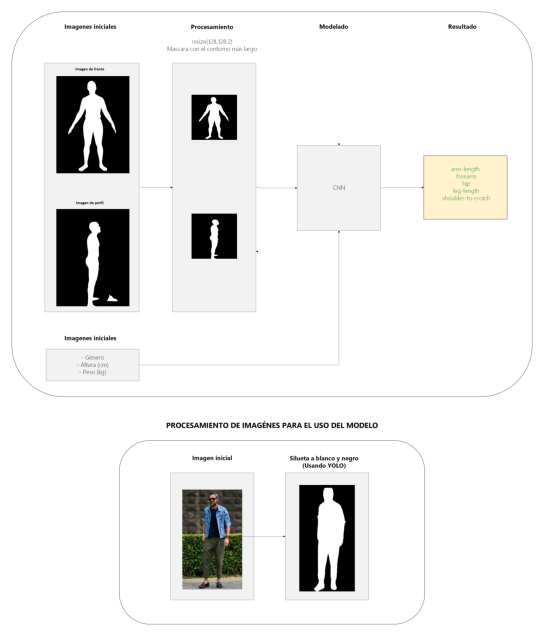

In [28]:
plt.figure(figsize=(12, 8))
plt.imshow(plt.imread('/content/drive/MyDrive/BodyM-Dataset/BodyMeasurementsProject.jpeg'))
plt.axis('off')  # Turn off axis labels and ticks
plt.show()

##**3. Modelado**

###**3.1 Modelo CNN**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
# Define input layers
image_input = Input(shape=(128, 128, 2), name='image_input')  # For image data
additional_features_input = Input(shape=(3,), name='additional_features_input')  # For height, weight and gender

# Image processing branch
x = layers.Conv2D(32, (3, 3), activation='relu')(image_input)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)

# Concatenate image features and additional features
merged = layers.concatenate([x, additional_features_input])

# Dense layers for prediction
x = layers.Dense(256, activation='relu')(merged)
output = layers.Dense(14, activation='linear')(x)

# Create the model
model1 = Model(inputs=[image_input, additional_features_input], outputs=output)

# Compile the model
model1.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Print model summary
model1.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)  │ (None, 128, 128, 2)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 126, 126, 32)   │            608 │ image_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 63, 63, 32)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 61, 61, 64)     │         18,496 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 30, 30, 64)     │              0 │ conv2d_4[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 28, 28, 128)    │         73,856 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 14, 14, 128)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 25088)          │              0 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ additional_features_input │ (None, 3)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 25091)          │              0 │ flatten_1[0][0],       │
│ (Concatenate)             │                        │                │ additional_features_i… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 256)            │      6,423,552 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 14)             │          3,598 │ dense_2[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 6,520,110 (24.87 MB)

 Trainable params: 6,520,110 (24.87 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history1 = model1.fit(
    [X.astype(np.float32), X_additional_features.astype(np.float32)], y.astype(np.float32), # Cast to float32
    validation_data=([X_test.astype(np.float32), X_additional_features_test.astype(np.float32)], y_test.astype(np.float32)), # Cast to float32
    epochs=50, batch_size=32
)

Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - loss: 1433.3970 - mae: 23.6385 - val_loss: 26.6204 - val_mae: 3.4220
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - loss: 42.7610 - mae: 4.4093 - val_loss: 21.4632 - val_mae: 3.0784
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - loss: 31.7673 - mae: 3.7741 - val_loss: 19.1804 - val_mae: 3.0225
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - loss: 26.4768 - mae: 3.4410 - val_loss: 37.0182 - val_mae: 4.3682
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - loss: 26.7865 - mae: 3.4762 - val_loss: 15.9001 - val_mae: 2.7334
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - loss: 20.9528 - mae: 3.1239 - val_loss: 12.9506 - val_mae: 2.5307
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - loss: 13.5829 - mae: 2.5611 - val_loss: 10.3436 - val_mae: 2.2293
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - loss: 10.8243 - mae: 2.2775 - val_loss: 9.3937 - val_mae: 2.1359
Epoch 9/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - lo

In [ ]:
# Evaluate the model on the test data
loss, mae = model1.evaluate([X_test.astype(np.float32), X_additional_features_test.astype(np.float32)], y_test.astype(np.float32), verbose=0)

# Make predictions on the test data
y_pred = model1.predict([X_test.astype(np.float32), X_additional_features_test.astype(np.float32)])

# Calculate R2 score
r2 = r2_score(y_test, y_pred)

print(f"Loss on test data: {loss:.4f}")
print(f"Mean Absolute Error on test data: {mae:.4f}")
print(f"R2 score on test data: {r2:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 260ms/step
Loss on test data: 5.8434
Mean Absolute Error on test data: 1.7145
R2 score on test data: 0.7720


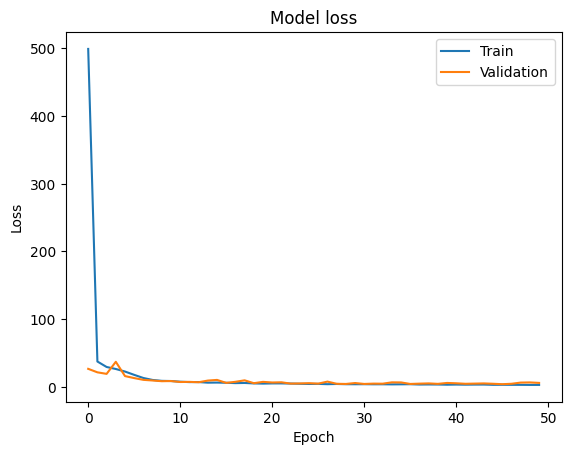

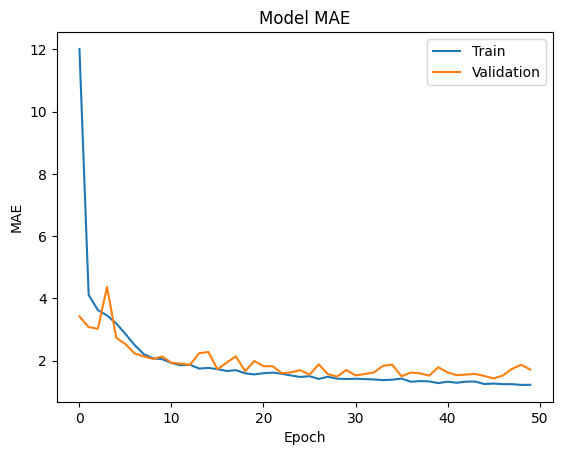

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

plt.plot(history1.history['mae'])
plt.plot(history1.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
# Get predictions on the training data
y_pred_train = model1.predict([X.astype(np.float32), X_additional_features.astype(np.float32)])

# Calculate the R2 score on training data
r2_train = r2_score(y, y_pred_train)

# Print the R2 score for training data
print(f"R2 score on training data: {r2_train:.4f}")

64/64 ━━━━━━━━━━━━━━━━━━━━ 17s 270ms/step
R2 score on training data: 0.8546


###**3.2 Modelo 2. CNN solo con 5 variables de respuesta**

In [ ]:
# Select only the desired measurements
selected_measurements_indices = [1, 5, 7, 8, 10]  # arm-length, forearm, hip, leg-length, shoulder-to-crotch
y_sel = y[:, selected_measurements_indices]
y_test_sel = y_test[:, selected_measurements_indices]


# Define input layers
image_input = Input(shape=(128, 128, 2), name='image_input')  # For image data
additional_features_input = Input(shape=(3,), name='additional_features_input')  # For height and weight

# Image processing branch
x = layers.Conv2D(32, (3, 3), activation='relu')(image_input)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)

# Concatenate image features and additional features
merged = layers.concatenate([x, additional_features_input])

# Dense layers for prediction
x = layers.Dense(256, activation='relu')(merged)
output = layers.Dense(5, activation='linear')(x)  # Assuming 5 body measurements

# Create the model
model6 = Model(inputs=[image_input, additional_features_input], outputs=output)

# Compile the model
model6.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Print model summary
model6.summary()
history6 = model6.fit(
    [X.astype(np.float32), X_additional_features.astype(np.float32)], y_sel.astype(np.float32), # Cast to float32
    validation_data=([X_test.astype(np.float32), X_additional_features_test.astype(np.float32)], y_test_sel.astype(np.float32)), # Cast to float32
    epochs=50, batch_size=32
)
print(history6.history)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)  │ (None, 128, 128, 2)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 126, 126, 32)   │            608 │ image_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 63, 63, 32)     │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 61, 61, 64)     │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 30, 30, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 28, 28, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 14, 14, 128)    │              0 │ conv2d_2[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 25088)          │              0 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ additional_features_input │ (None, 3)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 25091)          │              0 │ flatten[0][0],         │
│                           │                        │                │ additional_features_i… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │      6,423,552 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 5)              │          1,285 │ dense[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 6,517,797 (24.86 MB)

 Trainable params: 6,517,797 (24.86 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - loss: 13060.6953 - mae: 60.3079 - val_loss: 34.5867 - val_mae: 4.3210
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - loss: 31.1778 - mae: 4.0487 - val_loss: 24.7680 - val_mae: 3.8491
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - loss: 21.1868 - mae: 3.3687 - val_loss: 15.9781 - val_mae: 2.9604
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - loss: 17.3711 - mae: 3.0633 - val_loss: 15.2608 - val_mae: 3.0073
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - loss: 13.5811 - mae: 2.6923 - val_loss: 18.4759 - val_mae: 3.2769
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - loss: 11.1370 - mae: 2.4801 - val_loss: 12.0658 - val_mae: 2.6630
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - loss: 9.8246 - mae: 2.3390 - val_loss: 13.1263 - val_mae: 2.8391
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - loss: 8.2746 - mae: 2.1685 - val_loss: 12.7908 - val_mae: 2.7388
Epoch 9/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - lo

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step
Loss on test data: 8.5882
Mean Absolute Error on test data: 2.2551
R2 score on test data: 0.5896


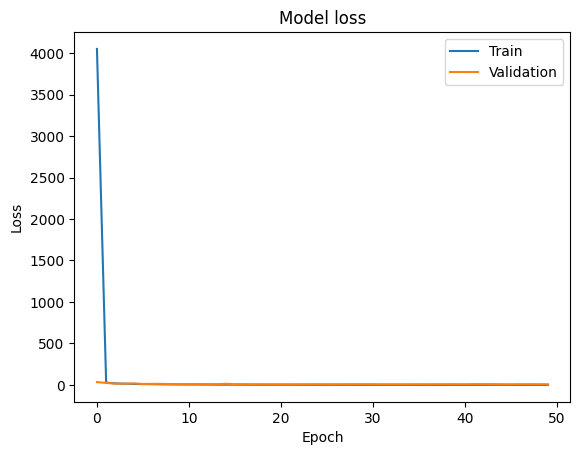

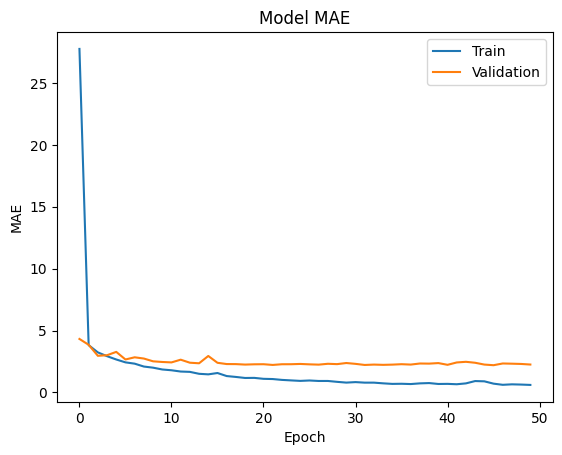

In [ ]:
from sklearn.metrics import r2_score

# Evaluate the model on the test data
loss, mae = model6.evaluate([X_test.astype(np.float32), X_additional_features_test.astype(np.float32)], y_test_sel.astype(np.float32), verbose=0)

# Make predictions on the test data
y_pred = model6.predict([X_test.astype(np.float32), X_additional_features_test.astype(np.float32)])

# Calculate the R2 score
r2 = r2_score(y_test_sel, y_pred) # Calculate R2 score here

print(f"Loss on test data: {loss:.4f}")
print(f"Mean Absolute Error on test data: {mae:.4f}")
print(f"R2 score on test data: {r2:.4f}")

plt.plot(history6.history['loss'])
plt.plot(history6.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

plt.plot(history6.history['mae'])
plt.plot(history6.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
y_pred_train_model6 = model6.predict([X.astype(np.float32), X_additional_features.astype(np.float32)])

# Calculate MAE using NumPy
mae_train_model6 = np.mean(np.abs(y_sel - y_pred_train_model6))

r2_train_model6 = r2_score(y_sel, y_pred_train_model6)

print(f"\nMAE on training data (Model 6): {mae_train_model6:.4f}")
print(f"R2 score on training data (Model 6): {r2_train_model6:.4f}")

64/64 ━━━━━━━━━━━━━━━━━━━━ 22s 348ms/step

MAE on training data (Model 6): 0.6357
R2 score on training data (Model 6): 0.9675


### **3.3 Modelo 2.1 Con regularización y Early Stopping para evitar overfitting**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
import numpy as np


#Select only the desired measurements
selected_measurements_indices = [1, 5, 7, 8, 10]  # arm-length, forearm, hip, leg-length, shoulder-to-crotch
y_sel = y[:, selected_measurements_indices]
y_test_sel = y_test[:, selected_measurements_indices]


# Define input layers
image_input = Input(shape=(128, 128, 2), name='image_input')  # For image data
additional_features_input = Input(shape=(3,), name='additional_features_input')  # For height and weight

# Image processing branch
x = layers.Conv2D(32, (3, 3), activation='relu')(image_input)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)

# Concatenate image features and additional features
merged = layers.concatenate([x, additional_features_input])

# Dense layers for prediction
x = layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))(merged)
output = layers.Dense(5, activation='linear', kernel_regularizer=keras.regularizers.l2(0.01))(x)

# Create the model
model2_1 = Model(inputs=[image_input, additional_features_input], outputs=output)

# Compile the model
model2_1.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Print model summary
model2_1.summary()

# Create an EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10) # Stop if val_loss doesn't improve for 10 epochs

# Train the model
history2_1 = model2_1.fit(
    [X.astype(np.float32), X_additional_features.astype(np.float32)], y_sel.astype(np.float32),
    validation_data=([X_test.astype(np.float32), X_additional_features_test.astype(np.float32)], y_test_sel.astype(np.float32)),
    epochs=50, batch_size=32,
    callbacks=[early_stopping]
)



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)  │ (None, 128, 128, 2)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 126, 126, 32)   │            608 │ image_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 63, 63, 32)     │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 61, 61, 64)     │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 30, 30, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 28, 28, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 14, 14, 128)    │              0 │ conv2d_2[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 25088)          │              0 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ additional_features_input │ (None, 3)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 25091)          │              0 │ flatten[0][0],         │
│                           │                        │                │ additional_features_i… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │      6,423,552 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 5)              │          1,285 │ dense[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 6,517,797 (24.86 MB)

 Trainable params: 6,517,797 (24.86 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - loss: 6490.4883 - mae: 41.6749 - val_loss: 40.4322 - val_mae: 4.5308
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - loss: 30.8833 - mae: 3.7195 - val_loss: 24.9468 - val_mae: 3.3197
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - loss: 22.3827 - mae: 3.1060 - val_loss: 21.5985 - val_mae: 3.0117
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - loss: 18.5472 - mae: 2.7735 - val_loss: 18.5019 - val_mae: 2.7044
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - loss: 16.6329 - mae: 2.6037 - val_loss: 17.3358 - val_mae: 2.6838
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - loss: 15.2470 - mae: 2.4789 - val_loss: 17.5913 - val_mae: 2.6793
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - loss: 13.8851 - mae: 2.2911 - val_loss: 16.7214 - val_mae: 2.5742
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - loss: 12.4633 - mae: 2.1572 - val_loss: 15.1473 - val_mae: 2.5420
Epoch 9/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - l

NameError: name 'model6' is not defined

In [ ]:
# Evaluate on test data
loss, mae = model2_1.evaluate([X_test.astype(np.float32), X_additional_features_test.astype(np.float32)], y_test_sel.astype(np.float32), verbose=0)
y_pred = model2_1.predict([X_test.astype(np.float32), X_additional_features_test.astype(np.float32)])
r2 = r2_score(y_test_sel, y_pred)

print(f"Loss on test data: {loss:.4f}")
print(f"Mean Absolute Error on test data: {mae:.4f}")
print(f"R2 score on test data: {r2:.4f}")

# Evaluate on training data
y_pred_train = model2_1.predict([X.astype(np.float32), X_additional_features.astype(np.float32)])
mae_train = np.mean(np.abs(y_sel - y_pred_train))
r2_train = r2_score(y_sel, y_pred_train)

print(f"\nMAE on training data: {mae_train:.4f}")
print(f"R2 score on training data: {r2_train:.4f}")

# Save the model
model2_1.save('model2_1_regularized.h5')

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 579ms/step
Loss on test data: 9.5113
Mean Absolute Error on test data: 1.9887
R2 score on test data: 0.6775
64/64 ━━━━━━━━━━━━━━━━━━━━ 20s 310ms/step



MAE on training data: 0.8201
R2 score on training data: 0.9441


Se seguirá trabajando en mejorar el modelo

###**3.4 Modelo: CNN con 5 salidas y solo la foto de frente**##

In [ ]:
# Assuming the front views are the first half of your samples.
X_front = X[:X.shape[0]//2]
X_front_test = X_test[:X_test.shape[0]//2]

In [ ]:
# Define input layers
image_input = Input(shape=(128, 128, 1), name='image_input')  # For image data (only front image)
additional_features_input = Input(shape=(3,), name='additional_features_input')  # For height and weight

# Image processing branch
x = layers.Conv2D(32, (3, 3), activation='relu')(image_input)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)

# Concatenate image features and additional features
merged = layers.concatenate([x, additional_features_input])

# Dense layers for prediction
x = layers.Dense(256, activation='relu')(merged)
output = layers.Dense(5, activation='linear')(x)  # Assuming 5 body measurements

# Create the model
model6_1 = Model(inputs=[image_input, additional_features_input], outputs=output)

# Compile the model
model6_1.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Print model summary
model6_1.summary()

# Assuming X_front is your array of front images (shape: (num_samples, 128, 128, 1))
history6_1 = model6_1.fit(
    [X_front.astype(np.float32), X_additional_features.astype(np.float32)], y_sel.astype(np.float32),
    validation_data=([X_front_test.astype(np.float32), X_additional_features_test.astype(np.float32)], y_test_sel.astype(np.float32)),
    epochs=50,
    batch_size=32
)

print(history6_1.history)


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)  │ (None, 128, 128, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_18 (Conv2D)        │ (None, 126, 126, 32)   │            320 │ image_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_18          │ (None, 63, 63, 32)     │              0 │ conv2d_18[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 61, 61, 64)     │         18,496 │ max_pooling2d_18[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_19          │ (None, 30, 30, 64)     │              0 │ conv2d_19[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 28, 28, 128)    │         73,856 │ max_pooling2d_19[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_20          │ (None, 14, 14, 128)    │              0 │ conv2d_20[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_6 (Flatten)       │ (None, 25088)          │              0 │ max_pooling2d_20[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ additional_features_input │ (None, 3)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_6             │ (None, 25091)          │              0 │ flatten_6[0][0],       │
│ (Concatenate)             │                        │                │ additional_features_i… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_12 (Dense)          │ (None, 256)            │      6,423,552 │ concatenate_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_13 (Dense)          │ (None, 5)              │          1,285 │ dense_12[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 6,517,509 (24.86 MB)

 Trainable params: 6,517,509 (24.86 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 65s 988ms/step - loss: 18943.7695 - mae: 59.1111 - val_loss: 29.4959 - val_mae: 4.2041
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 75s 875ms/step - loss: 29.7967 - mae: 3.8866 - val_loss: 19.5478 - val_mae: 3.2393
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 58s 913ms/step - loss: 23.1191 - mae: 3.3990 - val_loss: 16.8502 - val_mae: 3.0196
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 58s 909ms/step - loss: 18.7056 - mae: 3.0986 - val_loss: 20.1744 - val_mae: 3.3596
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 58s 909ms/step - loss: 18.2157 - mae: 3.1268 - val_loss: 14.3827 - val_mae: 2.8360
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 57s 898ms/step - loss: 12.2953 - mae: 2.6275 - val_loss: 13.4448 - val_mae: 2.7503
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 81s 887ms/step - loss: 11.2512 - mae: 2.5147 - val_loss: 12.4696 - val_mae: 2.6740
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 85s 921ms/step - loss: 9.7854 - mae: 2.3233 - val_loss: 16.1935 - val_mae: 3.0604
Epoch 9/50
64/64 ━━━━━━━━━━━━

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step
Loss on test data: 8.3498
Mean Absolute Error on test data: 2.1332
R2 score on test data: 0.6295


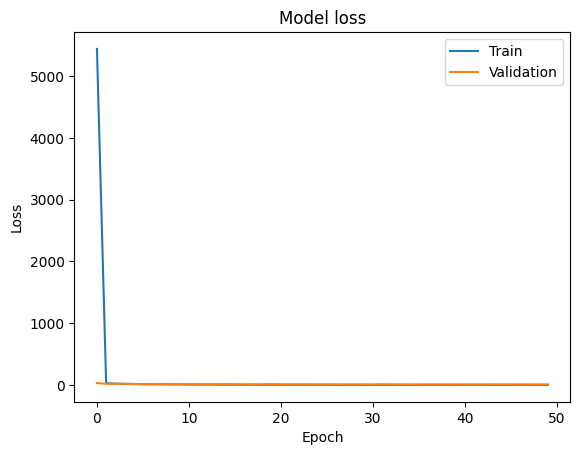

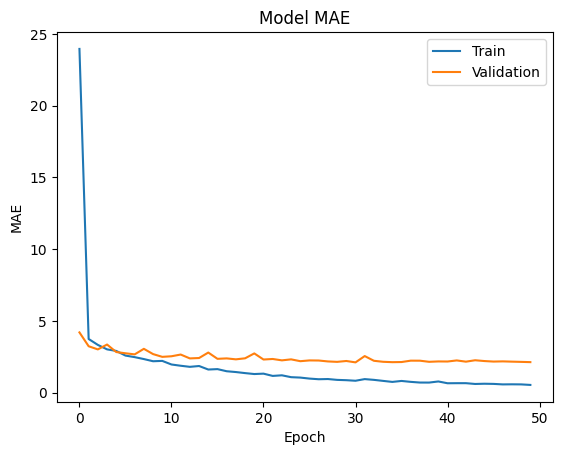

In [ ]:

# Evaluate the model on the test data
loss, mae = model6_1.evaluate([X_front_test.astype(np.float32), X_additional_features_test.astype(np.float32)], y_test_sel.astype(np.float32), verbose=0)

# Make predictions on the test data
y_pred = model6_1.predict([X_front_test.astype(np.float32), X_additional_features_test.astype(np.float32)])

print(f"Loss on test data: {loss:.4f}")
print(f"Mean Absolute Error on test data: {mae:.4f}")

# Calculate R2 score
r2 = r2_score(y_test_sel, y_pred)
print(f"R2 score on test data: {r2:.4f}")

plt.plot(history6_1.history['loss'])
plt.plot(history6_1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

plt.plot(history6_1.history['mae'])
plt.plot(history6_1.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
y_test_sel.shape

(87, 5)

In [ ]:
# Get predictions on the training data
y_pred_train = model6_1.predict([X_front.astype(np.float32), X_additional_features.astype(np.float32)])

# Calculate the R2 score on training data
r2_train = r2_score(y_sel, y_pred_train)

# Print the R2 score for training data
print(f"R2 score on training data: {r2_train:.4f}")

64/64 ━━━━━━━━━━━━━━━━━━━━ 18s 279ms/step
R2 score on training data: 0.9761


##**3.5 Modelo: Área y périmetro con regresión lineal**

In [ ]:
def calculate_area_perimeter(image, subject_id):
  """
  Calcula el área de la parte blanca y el perímetro del contorno de una imagen binaria.

  Args:
      image: Una imagen binaria (blanco y negro).
      subject_id: El ID del sujeto al que pertenece la imagen.

  Returns:
      Una tupla con el área y el perímetro.
  """
  contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  if not contours:
    return 0, 0  # Si no hay contornos, devolver 0 para el área y el perímetro

  # Encontrar el contorno con el área más grande (asumiendo que es el objeto principal)
  largest_contour = max(contours, key=cv2.contourArea)

  area = cv2.contourArea(largest_contour)
  perimeter = cv2.arcLength(largest_contour, True)

  return area, perimeter


# Crear DataFrames para almacenar los resultados
results_df_train = pd.DataFrame(columns=['subject_id', 'area', 'perimeter'])
results_df_test = pd.DataFrame(columns=['subject_id', 'area', 'perimeter'])

# Iterar sobre las imágenes de X_front (entrenamiento)
for i, image in enumerate(X_front):
  subject_id = photo_map.loc[i, 'subject_id']
  area, perimeter = calculate_area_perimeter(image, subject_id)
  results_df_train = pd.concat([results_df_train, pd.DataFrame({'subject_id': [subject_id], 'area': [area], 'perimeter': [perimeter]})], ignore_index=True)

# Iterar sobre las imágenes de X_front_test (prueba)
for i, image in enumerate(X_front_test):
  subject_id = photo_map_test.loc[i, 'subject_id']
  area, perimeter = calculate_area_perimeter(image, subject_id)
  results_df_test = pd.concat([results_df_test, pd.DataFrame({'subject_id': [subject_id], 'area': [area], 'perimeter': [perimeter]})], ignore_index=True)

# Unir results_df_train con los datos de entrenamiento
merged_df_train = pd.merge(results_df_train, hwg_metadata, on='subject_id', how='left')
merged_df_train = pd.merge(merged_df_train, measurements, on='subject_id', how='left')

# Unir results_df_test con los datos de prueba
merged_df_test = pd.merge(results_df_test, hwg_metadata_test, on='subject_id', how='left')
merged_df_test = pd.merge(merged_df_test, measurements_test, on='subject_id', how='left')

# Ahora tienes dos DataFrames: merged_df_train y merged_df_test
# con la información de área, perímetro, metadatos y mediciones
# para los conjuntos de entrenamiento y prueba, respectivamente.

print("DataFrame de entrenamiento:")
print(merged_df_train)

print("\nDataFrame de prueba:")
print(merged_df_test)

<ipython-input-28-1a03ad1ee538>:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df_train = pd.concat([results_df_train, pd.DataFrame({'subject_id': [subject_id], 'area': [area], 'perimeter': [perimeter]})], ignore_index=True)


DataFrame de entrenamiento:
                                       subject_id    area   perimeter  gender  \
0     -494U-YoXOD8e8gkCuyaRLn4MLo5P8Dm2B1s59WBGdg  3108.5  601.913775    male   
1     -5OHO2b5mRDY1rvAf07sYYtekEEX7ViEGmvRr7l4tfc  2793.5  563.085346  female   
2     -5iHTazqnmWBsnUY6ymoCw1kORMymRDaUla1eNOjgvI  2514.5  556.457933    male   
3     -60o95b9oEE83BDV3GpsAVPA4TFvxuPPqtXEY5PApy8  3040.0  572.014280    male   
4     -67TrwlJ3GSsqPeHaa2Nb0iQ-BKZfIx4ERysQPZ0-SY  2879.0  564.842707  female   
...                                           ...     ...         ...     ...   
2013  zqMxSbvyEBwZg0jFcfMR1B9fAq86pFKwQuOQ_Kjz_Lo  3636.5  571.570629  female   
2014  zrydWW1YldsSPK0Dey0YMyjPCF0jOvwBTfofxzTnNQI  2560.0  573.327989  female   
2015  ztF-PzganuRaZfhRBc44RANbhV4ff1VVXHRe6MgDYrI  2479.0  522.960458    male   
2016  ztYNUlq8M2d58t-fX1vsG5-JWNdZgtlUwYSBhDuryf8  2378.0  533.161468    male   
2017  zxWNGv-MTZSuC0Nx6fzyCJKLlpsfXZ-MDRmMX7pIKo0  2482.0  529.730010    male   


<ipython-input-28-1a03ad1ee538>:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df_test = pd.concat([results_df_test, pd.DataFrame({'subject_id': [subject_id], 'area': [area], 'perimeter': [perimeter]})], ignore_index=True)


In [ ]:
# Reemplazar los valores NaN en la columna 'gender' con 'Unknown'
merged_df_train['gender'] = merged_df_train['gender'].fillna('Unknown')

# Mapear los valores de género a numéricos usando un diccionario
gender_mapping = {'Male': 0, 'Female': 1, 'Unknown': 2}
merged_df_train['gender'] = merged_df_train['gender'].map(gender_mapping).fillna(2)

#Test
merged_df_test['gender'] = merged_df_test['gender'].fillna('Unknown')
merged_df_test['gender'] = merged_df_test['gender'].map(gender_mapping).fillna(2)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

# Seleccionar las características (X) y la variable objetivo (y)
X_reg = merged_df_train[['area', 'perimeter', 'height_cm', 'weight_kg']]  # Puedes agregar/eliminar características según sea necesario
y_reg = merged_df_train[['arm-length', 'forearm', 'hip', 'leg-length', 'shoulder-to-crotch']]


X_reg_test = merged_df_test[['area', 'perimeter', 'height_cm', 'weight_kg']]
y_reg_test = merged_df_test[['arm-length', 'forearm', 'hip', 'leg-length', 'shoulder-to-crotch']]

# Crear un modelo de regresión lineal
modellr = LinearRegression()

# Entrenar el modelo con los datos de entrenamiento
modellr.fit(X_reg, y_reg)

# Realizar predicciones en los datos de prueba
y_pred = modellr.predict(X_reg_test)

# Evaluar el modelo
mse = mean_squared_error(y_reg_test, y_pred)
r2 = r2_score(y_reg_test, y_pred)
mae = mean_absolute_error(y_reg_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")
print(f"Mean Absolute Error: {mae}")


Mean Squared Error: 4.54485547546562
R-squared: 0.8049950271964527
Mean Absolute Error: 1.5858252748291735


##**4. Procesamiento de imágenes para uso del modelo**

Las fotos que se usarán con la implementación del modelo corresponden a fotos a color de personas con diferentes fondos.

Teniendo en cuenta esto, se hace necesario realizar una segmentación donde el resultado sea una imagen de silueta a blanco y Negro.


**Conversión a imagen de silueta mediante YOLO**

In [ ]:
pip install opencv-python ultralytics numpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 876.6/876.6 kB 14.2 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO
import random
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
model = YOLO("yolov8m-seg.pt")

100%|██████████| 52.4M/52.4M [00:00<00:00, 119MB/s]


In [ ]:
# if you want all classes
yolo_classes = list(model.names.values())
classes_ids = [yolo_classes.index(clas) for clas in yolo_classes]

conf = 0.5
colors = [random.choices(range(256), k=3) for _ in classes_ids]

In [ ]:
img = cv2.imread("/content/drive/MyDrive/BodyM-Dataset/a97db0057fada9a0d8dae8de805a3732.jpg")


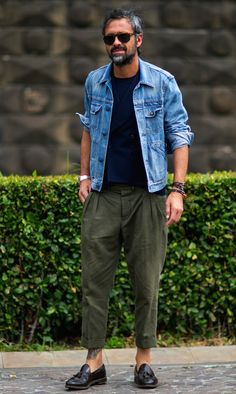

In [ ]:
cv2_imshow(img)


0: 640x384 1 person, 3588.7ms
Speed: 5.6ms preprocess, 3588.7ms inference, 7.4ms postprocess per image at shape (1, 3, 640, 384)


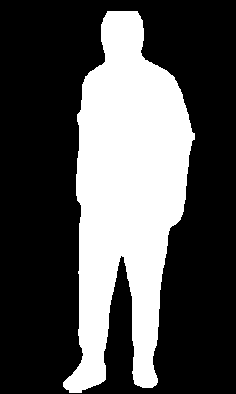

In [ ]:
results = model.predict(img, conf=conf)

black_image = np.zeros_like(img)

for result in results:
    for mask, box in zip(result.masks.xy, result.boxes):
        if int(box.cls[0]) == 0:  # Assuming class 0 is the person class
            points = np.int32([mask])
            # Fill the person's mask with white in the black image
            cv2.fillPoly(black_image, points, (255, 255, 255))

# Display the processed image
cv2_imshow(black_image)

Índice de la imagen seleccionada: 35
Forma de la imagen: (128, 128, 2)
Etiquetas de la imagen: [24.83498682294573 51.753221239362446 30.85057640075684 37.02972684587751
 106.59656524658205 28.031097684587756 182.2700384230841 99.75696418398904
 80.80187152680897 37.52137120564779 70.48967452276321 54.54051753452846
 90.96423012869698 17.186947686331614]
Características adicionales de la imagen: [  0.   180.45  81.35]


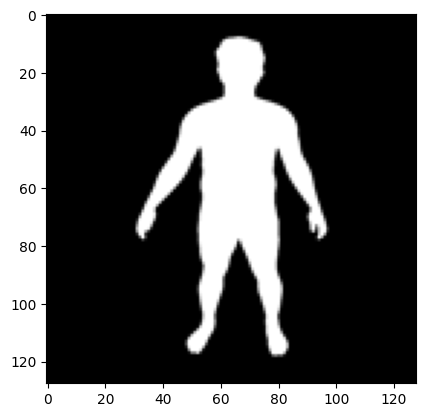

In [ ]:
# Escoge un índice aleatorio para la imagen de prueba
test_image_index = random.randint(0, len(X_test) - 1)

# Obtén la imagen y las etiquetas correspondientes
selected_image = X_test[test_image_index]
selected_labels = y_test[test_image_index]
selected_additional_features = X_additional_features_test[test_image_index]

# Imprime la información de la imagen seleccionada
print(f"Índice de la imagen seleccionada: {test_image_index}")
print(f"Forma de la imagen: {selected_image.shape}")
print(f"Etiquetas de la imagen: {selected_labels}")
print(f"Características adicionales de la imagen: {selected_additional_features}")

# Puedes visualizar la imagen si lo deseas
plt.imshow(selected_image[:,:,0], cmap="gray")
plt.show()


In [ ]:
# Para probar el modelo 6, puedes usar esta imagen y sus etiquetas:
# Ensure both inputs have the same number of samples (1 in this case)
# Reshape selected_image to (1, 128, 128, 2) and selected_additional_features to (1, 3)
predictions = model2_1.predict([selected_image.reshape(1, 128, 128, 2), selected_additional_features.reshape(1, 3)])

# Print or use the predictions as needed
print("Predictions:", predictions)
print("Real1", selected_labels[1])
print("Real2", selected_labels[5])
print("Real2", selected_labels[7])
print("Real2", selected_labels[8])
print("Real2", selected_labels[10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Predictions: [[ 50.288113  27.60908  102.8808    80.502625  69.79424 ]]
Real1 51.753221239362446
Real2 28.031097684587756
Real2 99.75696418398904
Real2 80.80187152680897
Real2 70.48967452276321
